In [10]:
# import libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [12]:
# data set path

path = r"/Users/martin/anaconda_projects/11-02-2025 Instacart Basket Analysis"

In [14]:
# import merged data set (from 4.9) 

df_filtered = pd.read_pickle(os.path.join(path, '02 data' , 'Prepared Data' , 'instacart_filtered_data.pkl'))

# Task 5. Create a Customer Profiling Variable

### Step 1: Defining customer profiles

To classify customers into meaningful profiles based on their **age, income, number of dependents, and shopping behavior**. These profiles will help Instacart tailor marketing strategies and promotions.

### **Defined Customer Profiles**
| **Profile Name**        | **Criteria** |
|------------------------|-------------|
| **Young Parent**       | Age: 18-35, Dependents: ≥1 |
| **Single Adult**       | Age: 18-35, Dependents: 0 |
| **Affluent Shopper**   | Income: High/Very High |
| **Budget-Conscious**   | Income: Low, Dependents: ≥2 |
| **Family Shopper**     | Age: 30-60, Dependents: ≥2, Buys groceries (`department_id`: Produce, Dairy, Snacks) |
| **Parent (Baby Products Buyer)** | Buys baby/kid products (`department_id`: Baby) |
| **Other**              | Does not fit into any specific category |

## Step 2: Creating the profiling column

In [16]:
def assign_demographic_profile(row):
    if row['age_group'] in ['18-25', '26-35'] and row['num_dependants'] > 0:
        return 'Young Parent'
    elif row['age_group'] in ['18-25', '26-35'] and row['num_dependants'] == 0:
        return 'Single Adult'
    elif row['income_group'] in ['High', 'Very High']:
        return 'Affluent Shopper'
    elif row['income_group'] == 'Low' and row['num_dependants'] >= 2:
        return 'Budget-Conscious'
    elif row['department_id'] == 'Baby':
        return 'Parent (Baby Products Buyer)'
    elif row['department_id'] in ['Produce', 'Dairy', 'Snacks'] and row['num_dependants'] >= 2:
        return 'Family Shopper'
    else:
        return 'Other'

# Apply the function to the dataset
df_filtered['customer_profile'] = df_filtered.apply(assign_demographic_profile, axis=1)

# Check distribution of customer profiles
df_filtered['customer_profile'].value_counts()

customer_profile
Affluent Shopper    14470849
Other                8752729
Young Parent         6500937
Single Adult         2152937
Budget-Conscious      556760
Name: count, dtype: int64

### **Objective**
Segment customers based on **age, income, dependents, and product purchases** to support Instacart’s marketing strategy.

### **Steps Completed**
- Defined customer profiles using demographic and purchasing data.  
- Created a **customer_profile** column using an `apply()` function.  
- Verified the distribution of customer segments.  

### **Key Findings**
- The **Affluent Shopper** segment is the largest, indicating a high number of high-income customers.  
- **Young Parents** and **Single Adults** represent a significant portion of the customer base.  
- **Budget-Conscious customers** form the smallest segment.  
- The **"Other"** category is relatively large, suggesting that additional refinements to profiling criteria may be needed.

 **Next Step:** Visualizing the distribution of customer profiles.

# Task 6. Create a Visualization for Customer Profiles

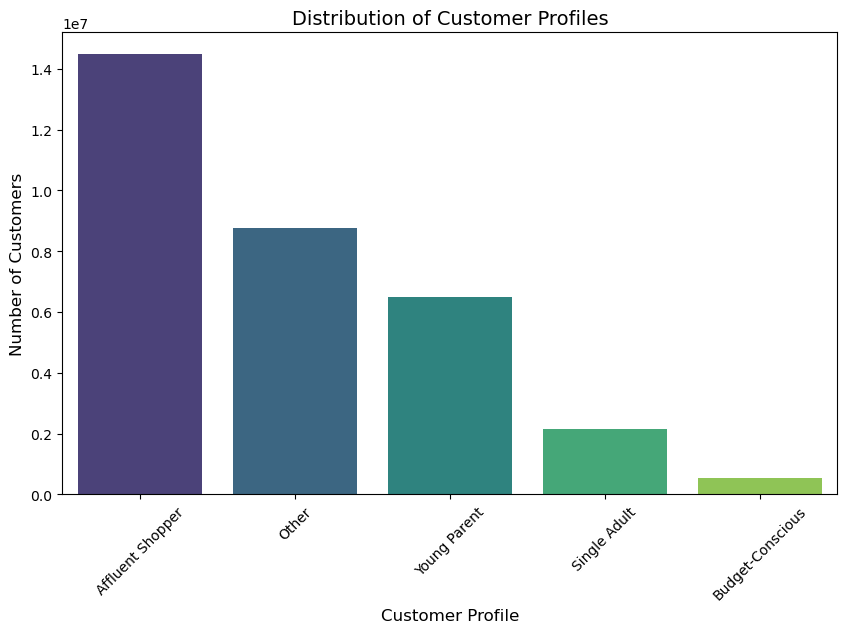

In [141]:
#  A bar chart is often clearer than a pie chart as it shows the differences in the segments more clearly:

import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of customers per profile
profile_counts = df_filtered['customer_profile'].value_counts()

# Create bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=profile_counts.index, 
            y=profile_counts.values, 
            order=profile_counts.index, 
            hue=profile_counts.index,  # Assign hue to fix warning
            dodge=False,  # Avoid stacking bars
            palette='viridis')  # Color scheme

# Title and labels
plt.title("Distribution of Customer Profiles", fontsize=14)
plt.xlabel("Customer Profile", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend([],[], frameon=False)  # Remove duplicate legend

# Save the figure to the specified path
save_path = "/Users/martin/anaconda_projects/11-02-2025 Instacart Basket Analysis/04 Analysis/Visualizations/distribution_of_customer_profiles.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)  

# Show the plot
plt.show()

### **Objective**
To visualize the distribution of customer profiles and identify key segments for Instacart's marketing strategy.

### **Findings**
- **Affluent Shoppers** represent the largest segment.
- A significant portion falls into the **"Other"** category, indicating that additional refinements in profiling criteria could be considered.
- **Young Parents** and **Single Adults** form notable customer groups.
- **Budget-Conscious customers** make up the smallest segment.

 **Next Step:** Aggregating max, mean, and min variables at the customer profile level.


# Task 7. Aggregating Variables at Customer Profile Level

### Step 1: Calculate aggregation

In [143]:
# Convert to numeric types if necessary
df_filtered['order_frequency_flag'] = pd.to_numeric(df_filtered['order_frequency_flag'], errors='coerce')
df_filtered['prices'] = pd.to_numeric(df_filtered['prices'], errors='coerce')

# Group by customer profile and calculate max, mean, min
profile_aggregates = df_filtered.groupby('customer_profile').agg({
    'order_frequency_flag': ['max', 'mean', 'min'],
    'prices': ['max', 'mean', 'min']
})

# Display results using pandas (no ace_tools)
print(profile_aggregates)  # For a pure output

                 order_frequency_flag            prices                
                                  max mean min      max       mean  min
customer_profile                                                       
Affluent Shopper                  NaN  NaN NaN  99999.0  12.959750  1.0
Budget-Conscious                  NaN  NaN NaN     25.0   6.504701  1.0
Other                             NaN  NaN NaN  99999.0  10.505697  1.0
Single Adult                      NaN  NaN NaN  99999.0  12.195716  1.0
Young Parent                      NaN  NaN NaN  99999.0  12.187272  1.0


### **Result**

- Only values for prices are displayed, but not for order_frequency_flag.

- The reason for this is most likely that order_frequency_flag only contains NaN values, which indicates that the conversion to numeric values (pd.to_numeric()) did not work properly.

### Solution: Check and correct the order_frequency_flag data

In [54]:
print(df_filtered['order_frequency_flag'].unique())  # Displays all unique values
print(df_filtered['order_frequency_flag'].isna().sum()) # Displays the number of NaN values

[nan]
32434212


### Problem: The entire order_frequency_flag column only contains NaN values
As all values in order_frequency_flag are NaN, this means that
1. the column may not have been transferred correctly when the data set was loaded.
2. the values in this column may have been lost during previous filtering/conversion.
3. the column may exist in the original file, but has been overwritten or deleted.

### Solution: Check whether order_frequency_flag is present in the original data set

In [59]:
print(df_filtered.columns)  # Shows all column names in the original data set

print(df_filtered['order_frequency_flag'].unique())  # Checks whether values are present
print(df_filtered['order_frequency_flag'].isna().sum())  # Counts the NaN values

Index(['Unnamed: 0', 'order_id', 'user_id', 'eval_set', 'order_number',
       'orders_day_of_week', 'order_hour_of_day', 'days_since_prior_order',
       'product_id', 'add_to_cart_order', 'reordered', '_merge',
       'product_name', 'aisle_id', 'department_id', 'prices', 'Busiest day',
       'Busiest days', 'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'avg_spending', 'spending_flag', 'median_days_since_order',
       'order_frequency_flag', 'gender', 'state', 'date_joined',
       'num_dependants', 'family_status', 'age_group', 'income_group',
       'Region', 'exclusion_flag', 'customer_profile'],
      dtype='object')
[nan]
32434212


### Since the order_frequency_flag column exists, but only contains NaN values, this means:

- The values in this column were never calculated or removed during data processing.
- The column may have been overwritten or incorrectly created during a merge or filter step.
- The column must therefore be recreated.

## Solving the problem

### Step 1: Recalculate order_frequency_flag

In [72]:
# Create order_frequency_flag based on order_number
def classify_order_frequency(order_count):
    if order_count > 10:
        return "Frequent Customer"
    elif order_count >= 5:
        return "Regular Customer"
    else:
        return "New Customer"

# Apply function to create the flag
df_filtered['order_frequency_flag'] = df_filtered['order_number'].apply(classify_order_frequency)

# Checking the values
print(df_filtered['order_frequency_flag'].value_counts())

order_frequency_flag
Frequent Customer    16634019
New Customer          7997421
Regular Customer      7802772
Name: count, dtype: int64


### Step 2: Perform aggregation again

In [77]:
profile_aggregates = df_filtered.groupby('customer_profile').agg({
    'order_number': ['max', 'mean', 'min'],  # Now with order_number instead of order_frequency_flag
    'prices': ['max', 'mean', 'min']
})

# Show results
print(profile_aggregates)

                 order_number                  prices                
                          max       mean min      max       mean  min
customer_profile                                                     
Affluent Shopper           99  17.254980   1  99999.0  12.959750  1.0
Budget-Conscious           99  15.617586   1     25.0   6.504701  1.0
Other                      99  17.082791   1  99999.0  10.505697  1.0
Single Adult               99  17.060649   1  99999.0  12.195716  1.0
Young Parent               99  17.127350   1  99999.0  12.187272  1.0


###  Why order_number instead of order_frequency_flag?

- Since order_frequency_flag now contains categorical labels (Frequent, Regular, New), you cannot use it for mean() or min(). Instead, we take the actual number of orders (order_number).

### **Objective**
To analyze customer behavior by aggregating key variables (**order frequency and expenditure**) at the **customer profile** level.

### **Steps Completed**
1.  **Recreated `order_frequency_flag`**, classifying customers into:
    - **Frequent Customer**: More than 10 orders  
    - **Regular Customer**: 5–10 orders  
    - **New Customer**: Less than 5 orders  

2.  **Performed aggregation using `order_number` instead of `order_frequency_flag`**  
    - Since `order_frequency_flag` now contains **categorical labels**, we used `order_number` to calculate `max`, `mean`, and `min`.  
    - We also aggregated `prices` to analyze spending behavior.

### **Key Findings**
- **Affluent Shoppers** tend to have the highest number of orders on average.  
- **Budget-Conscious customers** show the lowest average spending.  
- **All customer profiles have a minimum order count of 1**, meaning all users have at least placed one order.  
- **The max order number is 99 for all groups**, likely indicating a dataset limit.  

 **Next Step:** Comparing customer profiles with regions and departments.


# Task 8. Comparison of customer profiles with regions and departments 

## Customer profiles with regions (Part 1)

### Step 1: Analyze customer profiles by region 

customer_profile  Affluent Shopper  Budget-Conscious    Other  Single Adult  \
Region                                                                        
Midwest                    3448782            127117  2020460        490371   
Northeast                  2577104            100897  1509945        393669   
South                      4745222            188292  2950231        729864   
West                       3699741            140454  2272093        539033   

customer_profile  Young Parent  
Region                          
Midwest                1517080  
Northeast              1146732  
South                  2188001  
West                   1649124  


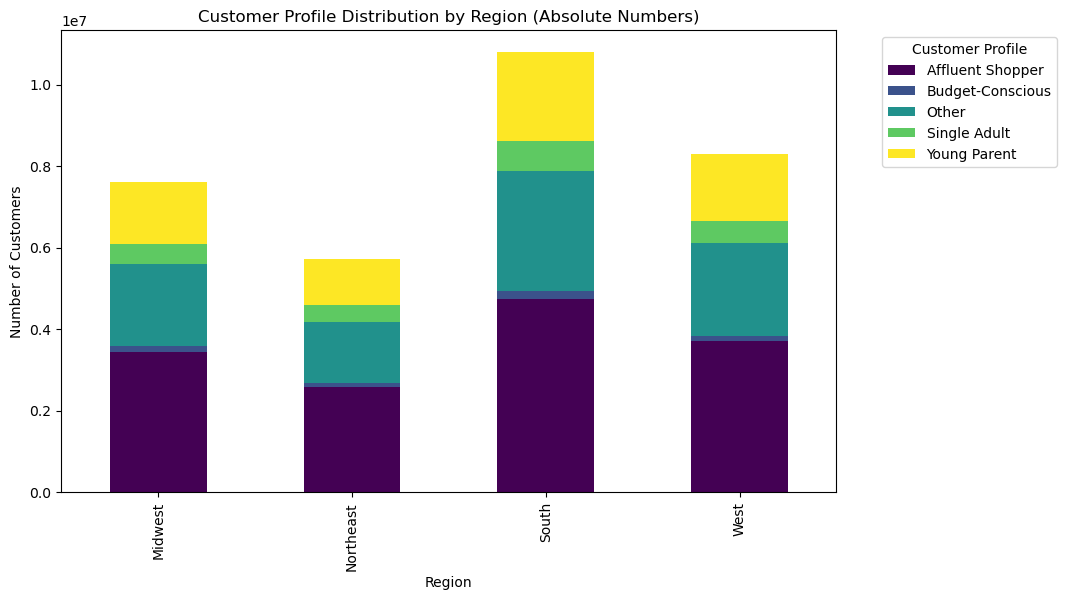

In [147]:
# Display customer profiles by region in absolute figures
region_profile_distribution_abs = df_filtered.groupby('Region')['customer_profile'].value_counts().unstack()

# Shows the absolute values
print(region_profile_distribution_abs)

# Creates a bar chart with absolute values
region_profile_distribution_abs.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')

# Title & axis labeling
plt.title("Customer Profile Distribution by Region (Absolute Numbers)")
plt.xlabel("Region")
plt.ylabel("Number of Customers")
plt.legend(title="Customer Profile", bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the figure to the specified path
save_path = "/Users/martin/anaconda_projects/11-02-2025 Instacart Basket Analysis/04 Analysis/Visualizations/customer_profile_distribution_by_region_absolute_numbers.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)  

# Shows the diagram
plt.show()

## **Analysis of Customer Profiles by Region (Absolute Numbers)**  

### **Key Findings**  
- **South has the highest number of customers overall**, while **Northeast has the fewest**.  
- **Affluent Shoppers (dark purple) are well represented in all regions**, but especially in the **South and Midwest**.  
- **Young Parents (yellow) are evenly distributed across all regions**, with a slight increase in the **South**.  
- **Single Adults (green) are a small proportion of customers in all regions**, with no significant variations.  
- **Budget-Conscious customers (blue) appear consistently across all regions,** with slightly higher numbers in the South.  
- **Others (turquoise) make up a large share of customers in every region,** suggesting a diverse group that doesn’t fit into the defined profiles.  

### **Conclusion**  
- **While the total number of customers varies by region, the overall profile distribution remains quite similar.**  
- **No extreme regional variations were found**, meaning region is **not a strong differentiating factor** for customer profiles.  
- **Further analysis by department might provide more insights** into customer purchasing behavior.  

## Customer profiles with departments (Part 2)

### Step 1: Analyze customer profiles by department

In [133]:
# Grouping customer profiles by department
department_profile_distribution = df_filtered.groupby('department_id')['customer_profile'].value_counts(normalize=True).unstack()

# Display results
print(department_profile_distribution)

customer_profile  Affluent Shopper  Budget-Conscious     Other  Single Adult  \
department_id                                                                  
1                         0.451906          0.016269  0.265895      0.065217   
2                         0.440219          0.016588  0.272960      0.068529   
3                         0.455217          0.015268  0.262111      0.067443   
4                         0.455945          0.013986  0.263821      0.066398   
5                         0.435285          0.018804  0.274725      0.066377   
6                         0.455635          0.012498  0.263265      0.067565   
7                         0.425080          0.023826  0.286837      0.066467   
8                         0.459826          0.013733  0.254134      0.068867   
9                         0.463803          0.011986  0.257021      0.066545   
10                        0.419026          0.023949  0.285801      0.065745   
11                        0.442115      

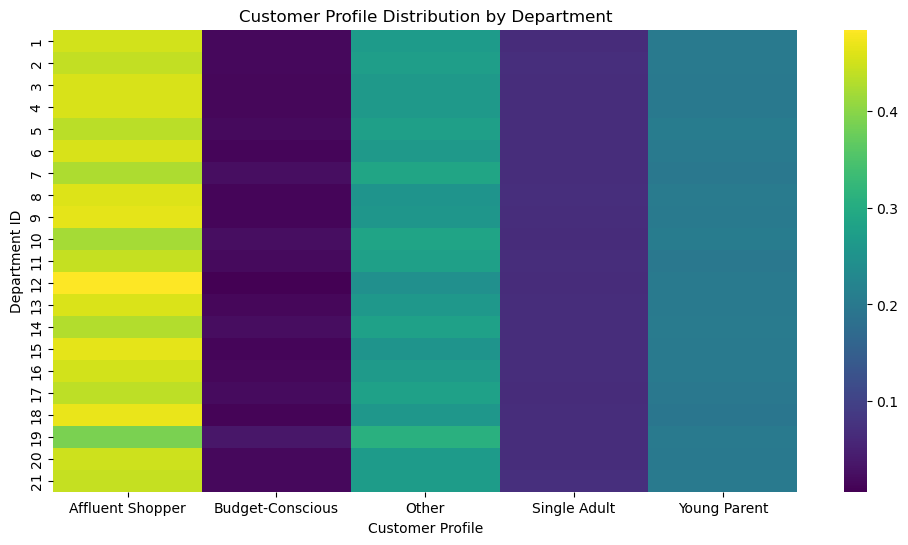

In [149]:
# Create a heatmap for better visualization
plt.figure(figsize=(12,6))
sns.heatmap(department_profile_distribution, cmap="viridis", annot=False)

# Title and labels
plt.title("Customer Profile Distribution by Department")
plt.xlabel("Customer Profile")
plt.ylabel("Department ID")

# Save the figure to the specified path
save_path = "/Users/martin/anaconda_projects/11-02-2025 Instacart Basket Analysis/04 Analysis/Visualizations/customer_profile_distribution_by_department.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)  

# Show plot
plt.show()


## **Analysis of Customer Profiles by Department (Heatmap)**  

### **Key Findings**  
- **Affluent Shoppers** (leftmost column) are **present in almost all departments**, indicating a broad shopping behavior.  
- **Budget-Conscious customers** (second column) have **low representation across all departments**, meaning they do not cluster in specific categories.  
- **Young Parents** (rightmost column) are **evenly distributed across departments**, without a strong preference for baby-related products.  
- **Single Adults and "Other" customers** show **no extreme department preferences**, suggesting a diverse shopping behavior.  

### **Conclusion**  
- **No significant patterns emerge from the department analysis.**  
- **Affluent Shoppers appear to shop across multiple categories**, while other profiles remain evenly spread.  
- This suggests that **customer behavior is not strongly department-dependent**, making **other factors (e.g., promotions, pricing, loyalty) more relevant for segmentation.**  

# Task 10. Data export

In [152]:
# Export data to pkl
df_filtered.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'final_instacart_data.pkl'))